In [1]:
import scanpy as sc
import numpy as np
import muon as mu
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/home/sergey/data/clonal_project"
HOME_PATH = "/home/sergey/projects/clonal_project"

# Additional functions
exec(open(f"{HOME_PATH}/tools/tools.py").read())
sns.set_style("ticks")

2023-02-08 18:54:44.363726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 18:54:44.622468: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-08 18:54:45.531468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sergey/miniconda3/envs/sc/lib
2023-02-08 18:54:45.531583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

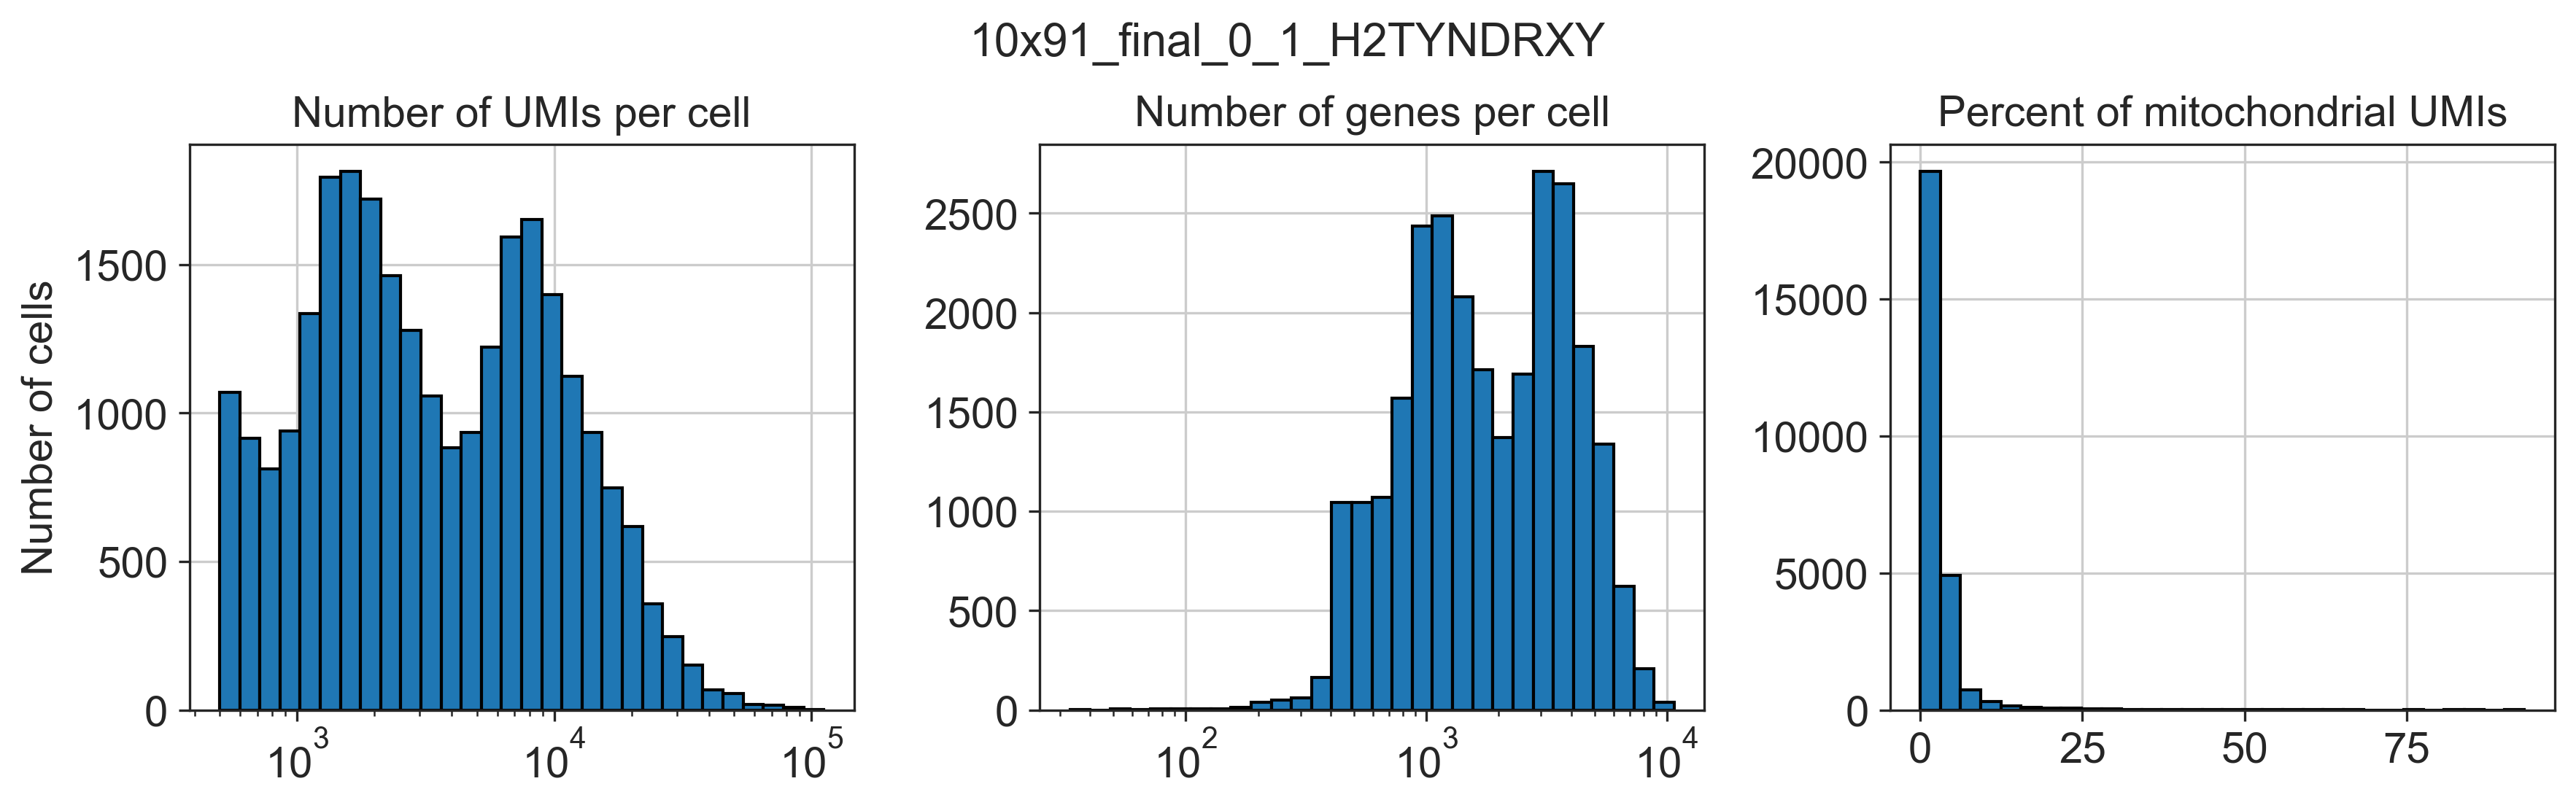

In [128]:
adata = sc.read_10x_h5("/home/sergey/10x91_run1_cellranger.h5")
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=None, log1p=False, qc_vars=["mt"])
qc_plot = draw_counts_qc(adata, title="10x91_final_0_1_H2TYNDRXY")

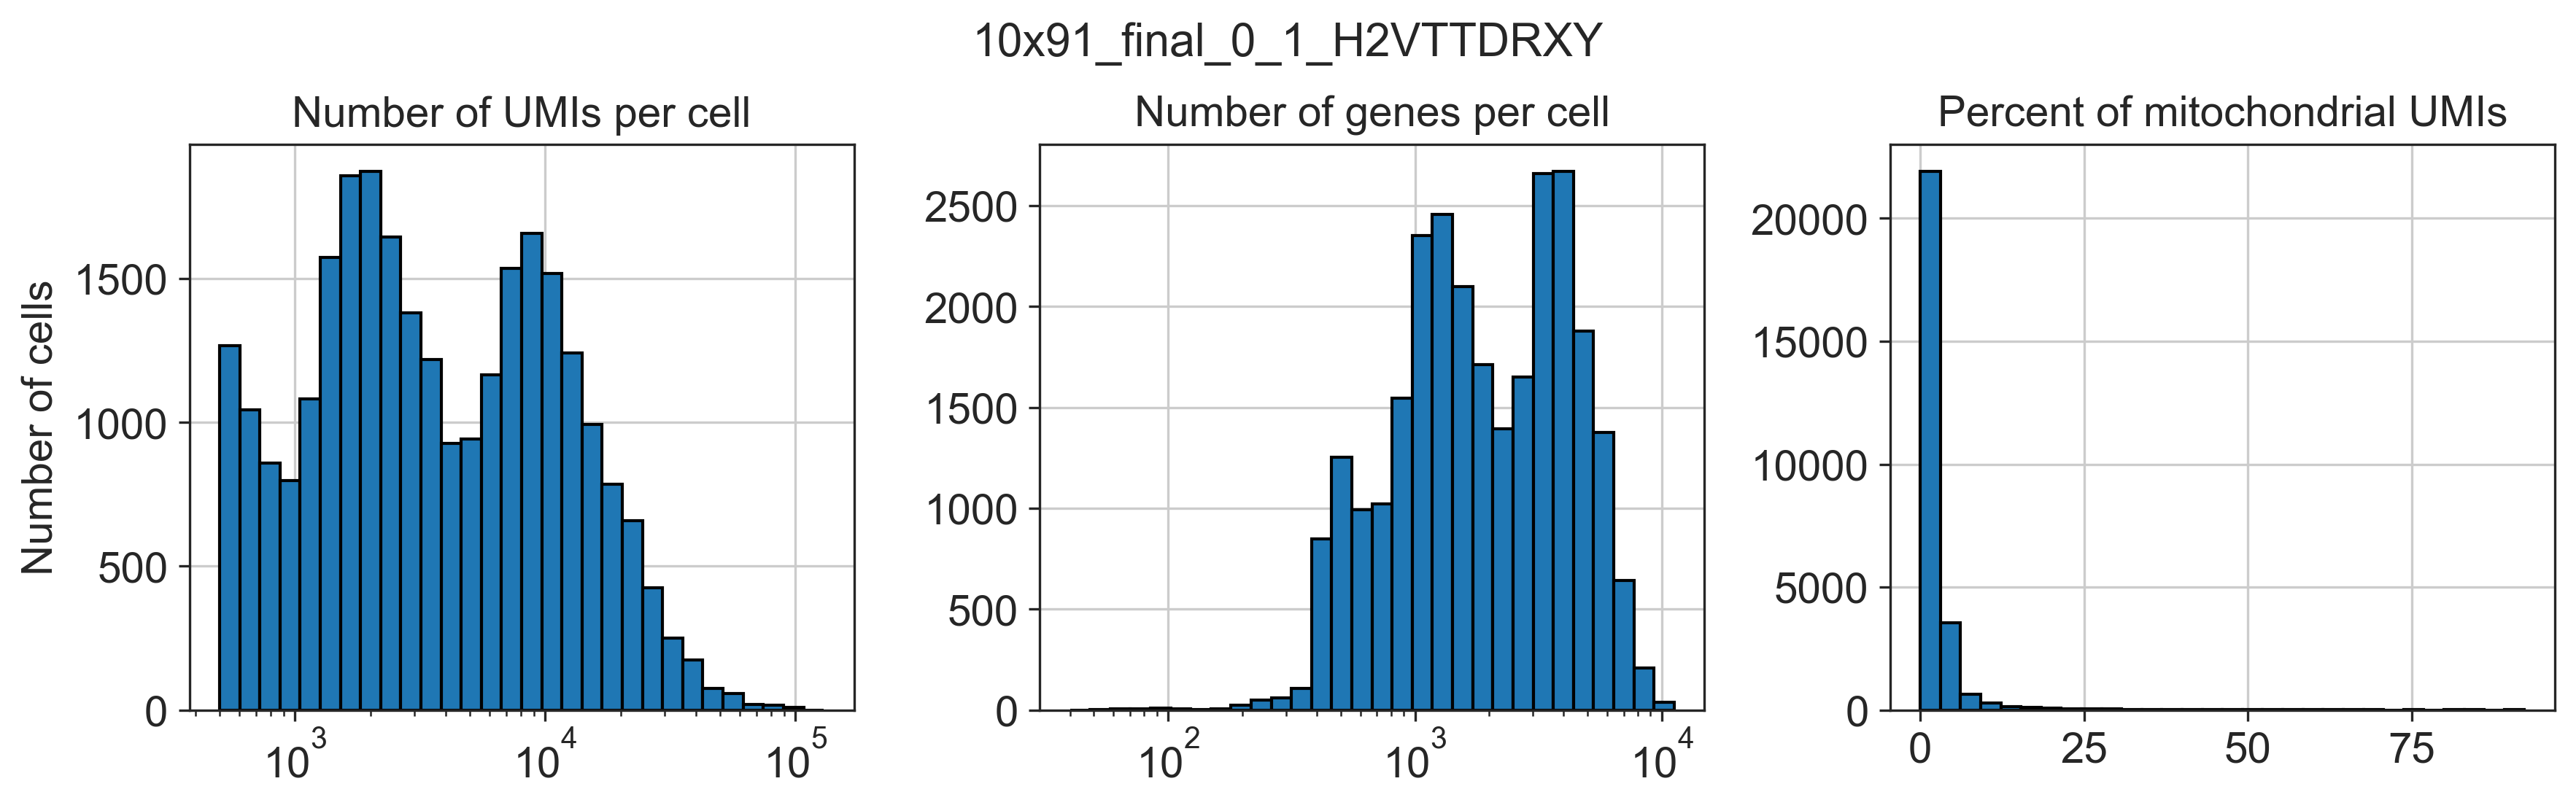

In [129]:
adata = sc.read_10x_h5("/home/sergey/10x91_run2_cellranger.h5")
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=None, log1p=False, qc_vars=["mt"])
qc_plot = draw_counts_qc(adata, title="10x91_final_0_1_H2VTTDRXY")

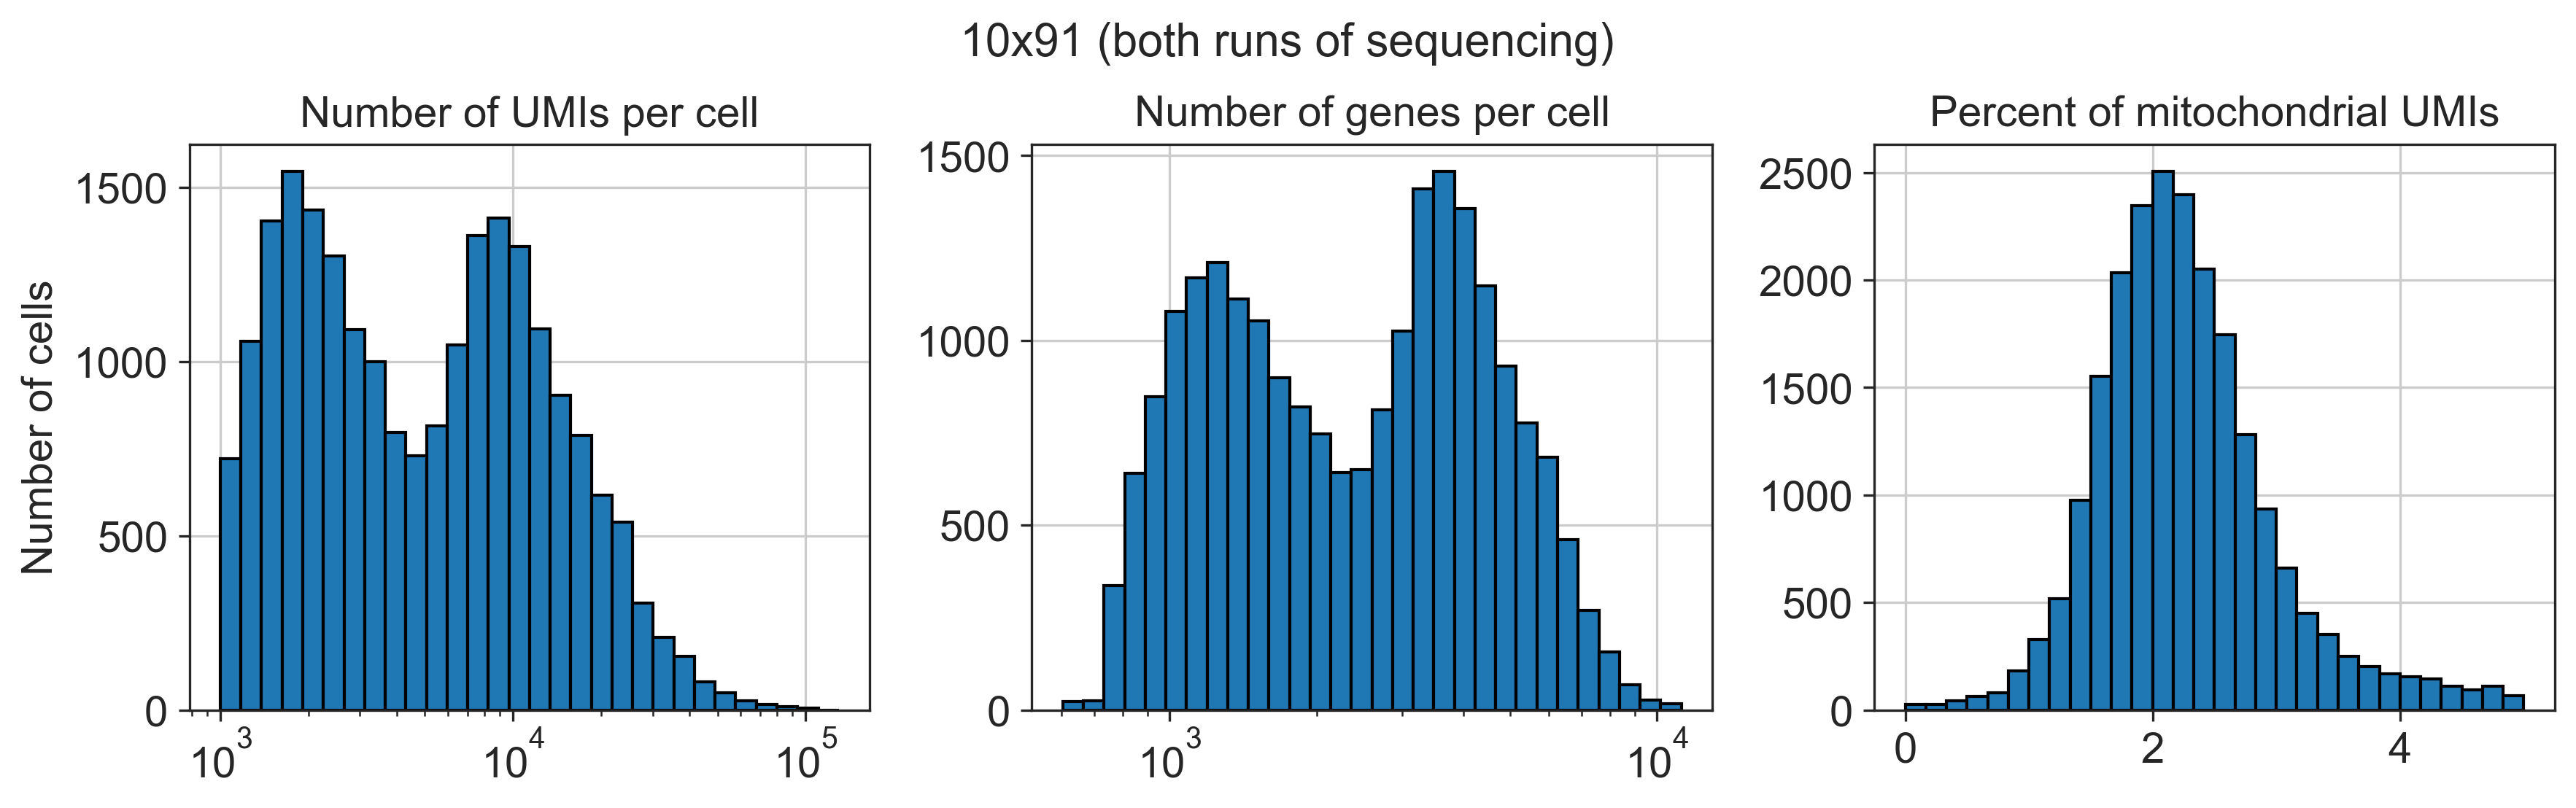

In [9]:
mdata = mu.read_h5mu("/home/sergey/data/clonal_project/anndatas_counts/10x91_lowquality.h5mu")
qc_plot = draw_counts_qc(mdata["GEX"], title="10x91 (both runs of sequencing)")

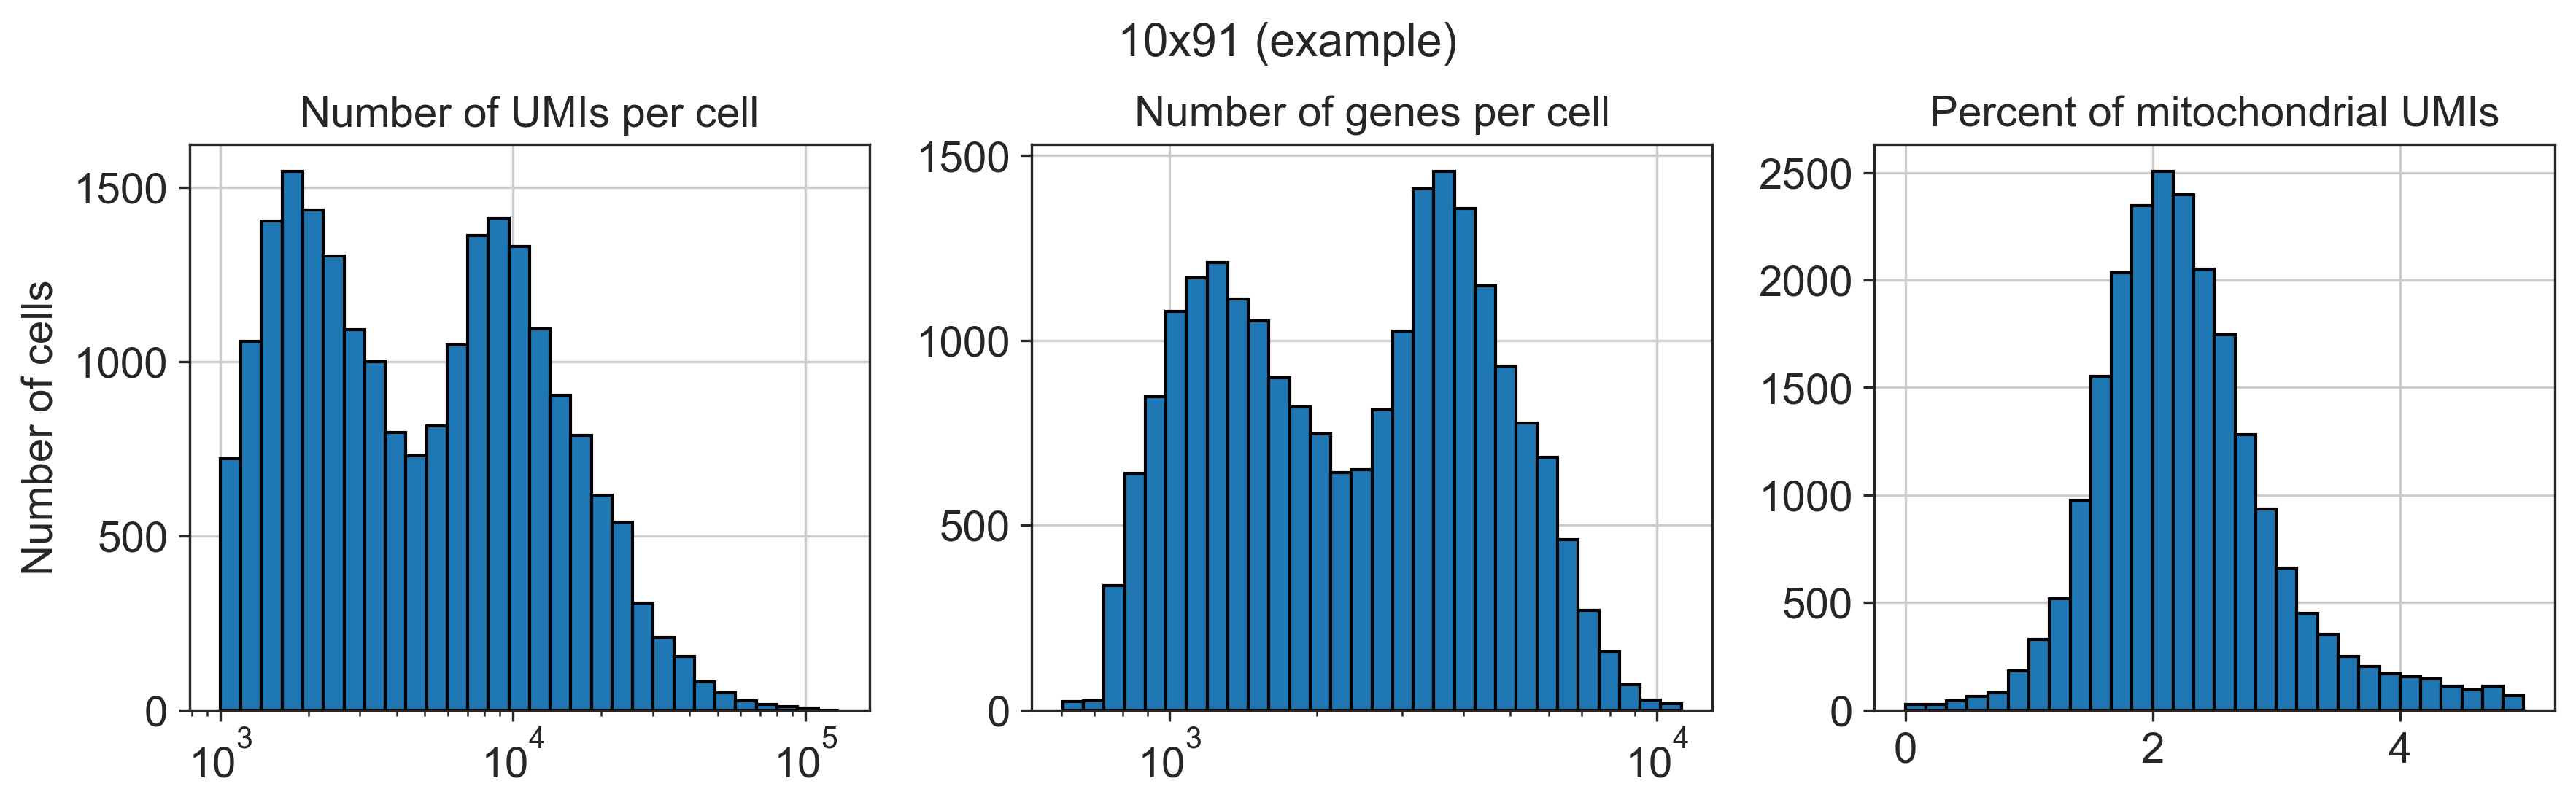

In [117]:
qc_plot = draw_counts_qc(mdata["GEX"], title="10x91 (example)")

In [11]:
adata = mdata["GEX"].copy()
adata.var_names_make_unique()
mdata = mu.MuData({
    "GEX": adata,
    "GFPbc": mdata["GFPbc"], 
    "TOMbc": mdata["TOMbc"],
})

In [12]:
mdata.obs["TOMbc_clones"] = fast_clones(mdata["TOMbc"], min_cloneID_umi=2)
mdata.obs["GFPbc_clones"] = fast_clones(mdata["GFPbc"], min_cloneID_umi=2)

In [13]:
mdata.obs["QC_mode"] = ["Low" if n < 4000 else "High" for n in mdata["GEX"].obs.total_counts]
mdata_low = mdata[mdata.obs.QC_mode == "Low"]
mdata_high = mdata[mdata.obs.QC_mode == "High"]

In [14]:
# High quality cells clustering
sc.pp.normalize_total(mdata_high["GEX"], target_sum=1e5) # 1e5 will be used for query
sc.pp.log1p(mdata_high["GEX"])
sc.pp.highly_variable_genes(
    mdata_high["GEX"],
    n_top_genes=3000,
)
mdata_high["GEX"].raw = mdata_high["GEX"]
sc.pp.scale(mdata_high["GEX"], max_value=10)
sc.pp.pca(mdata_high["GEX"], n_comps=30)
sc.pp.neighbors(mdata_high["GEX"])
sc.tl.umap(mdata_high["GEX"])
sc.tl.leiden(mdata_high["GEX"], resolution=0.5)

In [15]:
# Low quality cells preprocessing and label transfer
sc.pp.normalize_total(mdata_low["GEX"], target_sum=1e5)
sc.pp.log1p(mdata_low["GEX"])

import symphonypy as sp
sp.tl.map_embedding(
    adata_query=mdata_low["GEX"],
    adata_ref=mdata_high["GEX"],
)
sp.tl.ingest(
    adata_query=mdata_low["GEX"],
    adata_ref=mdata_high["GEX"],
    use_rep="X_pca_harmony",
)
sp.tl.transfer_labels_kNN(
    adata_query=mdata_low["GEX"],
    adata_ref=mdata_high["GEX"],
    ref_labels="leiden",
    ref_basis="X_pca",
    query_basis="X_pca_harmony",
)

In [22]:
celltype_colors = dict(zip(
    mdata_high["GEX"].obs["leiden"].cat.categories,
    mdata_high["GEX"].uns["leiden_colors"],
))
mdata_low["GEX"].uns["leiden_colors"] = [
    celltype_colors[ct] for ct in mdata_low["GEX"].obs["leiden"].cat.categories
]

<AxesSubplot:title={'center':'High quality'}, xlabel='UMAP1', ylabel='UMAP2'>

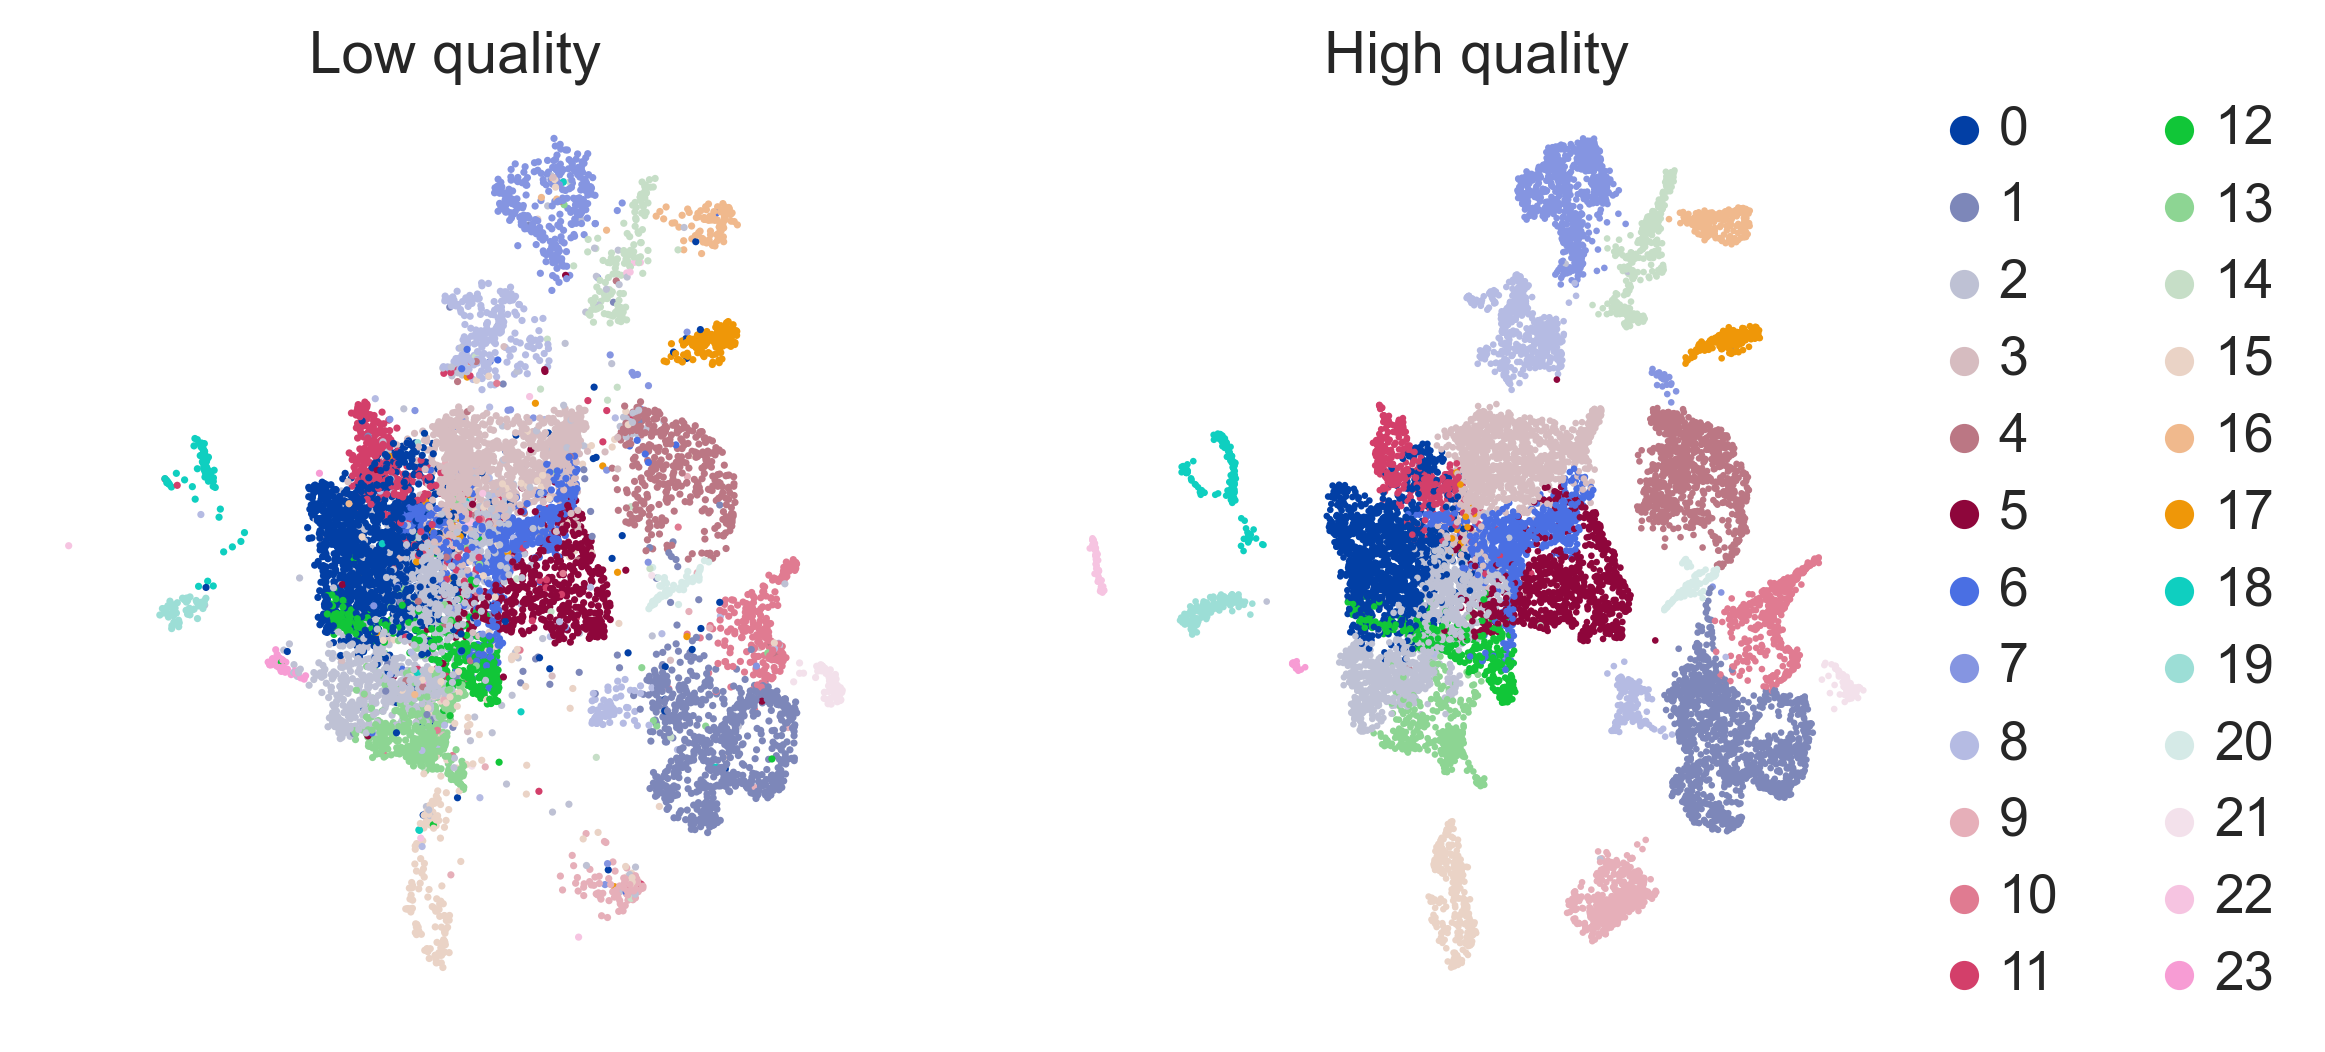

In [23]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(
    mdata_low["GEX"],
    color="leiden",
    frameon=False,
    title="Low quality",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    mdata_high["GEX"],
    color="leiden",
    frameon=False,
    title="High quality",
    ax=axes[1],
    show=False,
)

(-0.00024091293322062553, 0.007)

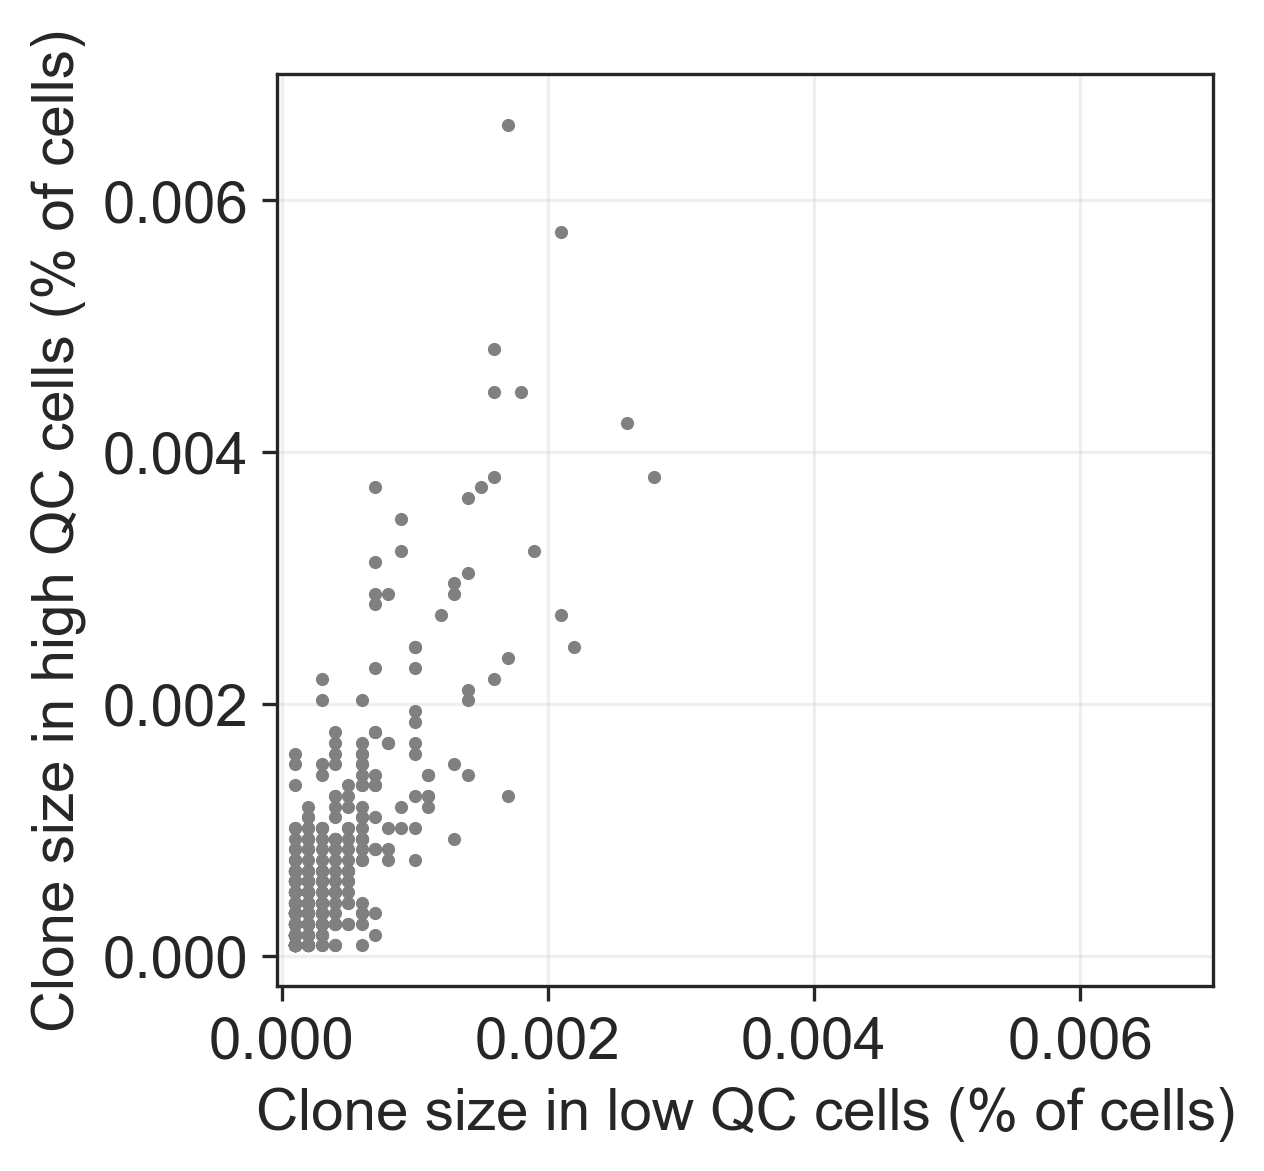

In [132]:
clone_sizes = pd.DataFrame([
    mdata_low.obs["GFPbc_clones"].value_counts()[1:] / len(mdata_low.obs["GFPbc_clones"]),
    mdata_high.obs["GFPbc_clones"].value_counts()[1:] / len(mdata_high.obs["GFPbc_clones"]),
], index=["Low", "High"]).T.dropna()
ax = sns.scatterplot(x="Low", y="High", data=clone_sizes, linewidth=0, s=10, color="grey")
ax.grid(alpha=0.3)
ax.set_xlabel("Clone size in low QC cells (% of cells)")
ax.set_ylabel("Clone size in high QC cells (% of cells)")
ax.set_xlim(None, 0.007)
ax.set_ylim(None, 0.007)

In [104]:
min_clonesize = 10
compositions = pd.DataFrame()
counts = pd.DataFrame()
for clone in clone_sizes[(clone_sizes.Low >= min_clonesize) & (clone_sizes.High >= min_clonesize)].index:
    composition = pd.DataFrame([
        mdata_high[mdata_high.obs["GFPbc_clones"] == clone]["GEX"].obs.leiden.value_counts(),
        mdata_low[mdata_low.obs["GFPbc_clones"] == clone]["GEX"].obs.leiden.value_counts(),
    ], index=["High", "Low"]).fillna(0)
    counts = counts.append(composition.T)
    composition = (composition.T / composition.sum(axis=1))
    composition["cluster"] = composition.index
    compositions = compositions.append(composition)

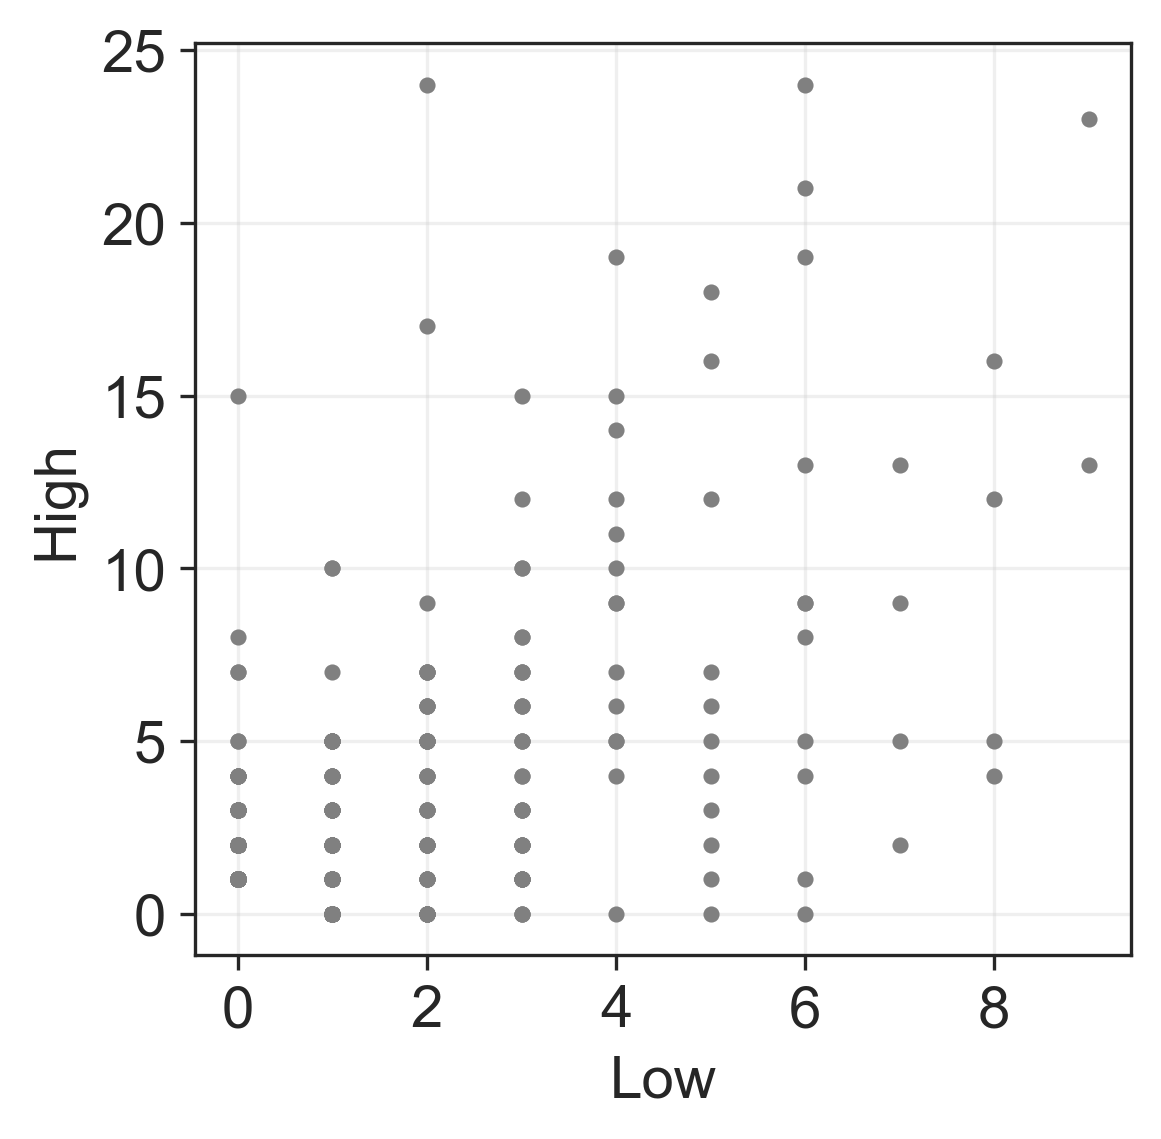

In [108]:
ax = sns.scatterplot(
    x="Low",
    y="High",
    data=counts,
    linewidth=0,
    s=15,
    color="grey",
)
ax.grid(alpha=0.3)

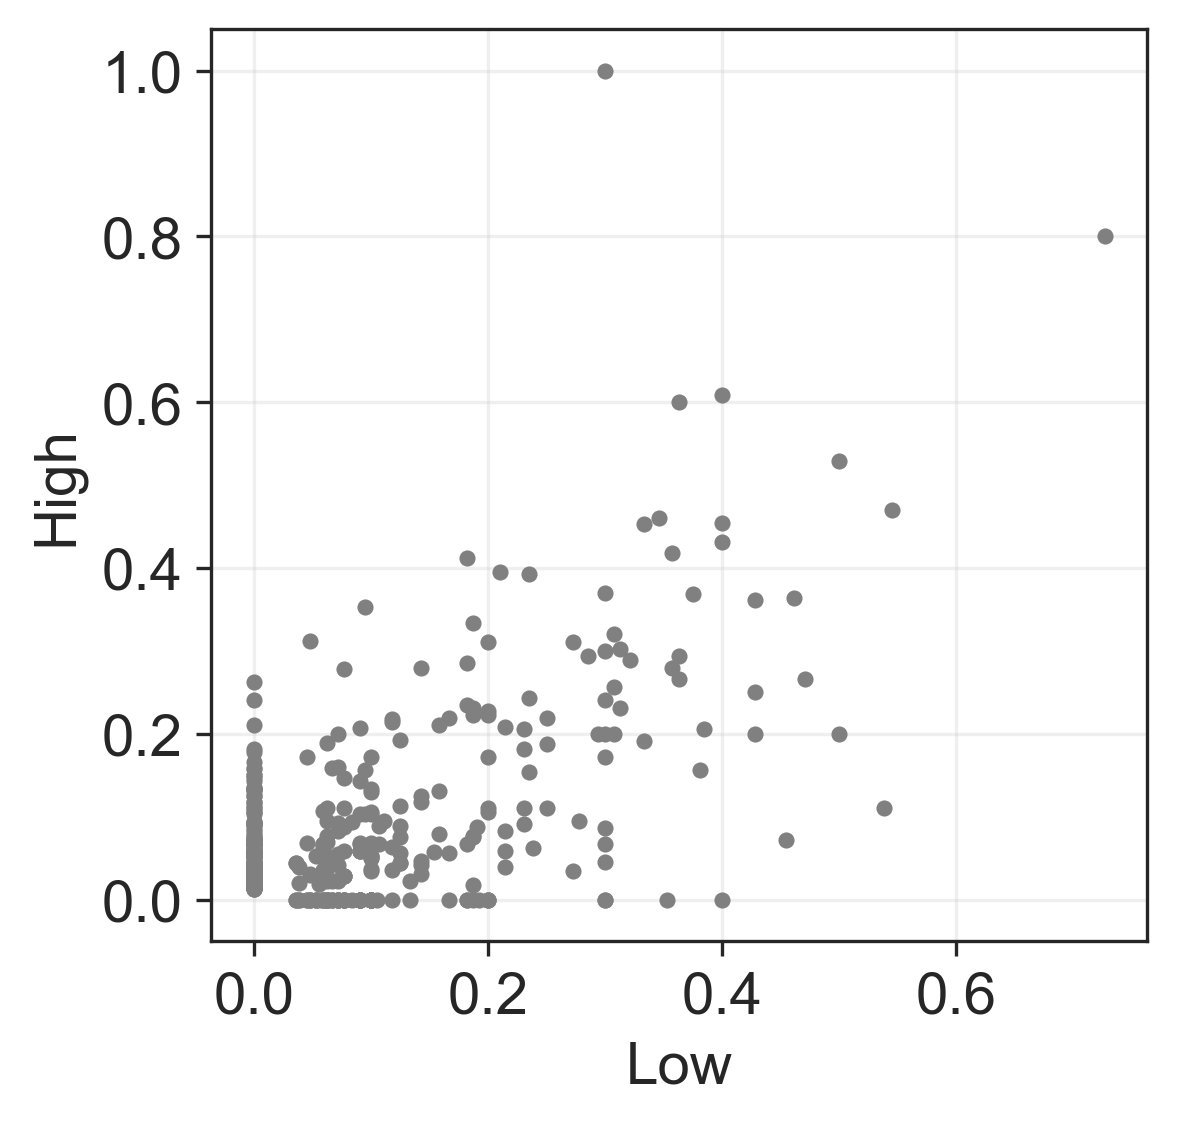

In [143]:
ax = sns.scatterplot(
    x="Low",
    y="High",
    data=compositions,
    linewidth=0,
    s=15,
    color="grey",
)
ax.grid(alpha=0.3)

In [116]:
from scipy.stats import pearsonr

pearsonr(compositions.Low, compositions.High)[0]

0.619164543187364

In [126]:
sum(mdata_low.obs["TOMbc_clones"] == "Unknown") / len(mdata_low["GEX"])

0.9174897735209019

In [125]:
sum(mdata_high.obs["TOMbc_clones"] == "Unknown") / len(mdata_low["GEX"])

0.8753866107951711